This notebook demonstrates hyperparameter tuning experiments and goes together with my lecture https://github.com/prokudin/PHYS496-Fall2024/blob/main/Lectures/AI%20and%20ML%20Lecture%20IV%20hyperparameters%20tuning.pptx

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install torchinfo

In [3]:
# Imports necessary libraries

# PyTorch core libraries
import torch  # Provides core functionalities for tensors and computation on GPU
import torch.nn as nn  # Helps in building neural networks by providing layers and modules
import torch.optim as optim  # Provides optimization algorithms such as Adam, SGD
from torchinfo import summary # provides text summary of the model
import torch.nn.functional as F # we will use activation functions this way

# PyTorch utilities for handling datasets
from torch.utils.data import Dataset, TensorDataset, DataLoader
# Dataset: Abstract class for all datasets
# TensorDataset: Wraps tensors into a dataset object
# DataLoader: Loads data in batches for training or testing
# Import random_split from PyTorch to split datasets into training and testing sets
from torch.utils.data import random_split


# Pandas for data manipulation
import pandas as pd  # Provides data structures like DataFrame for handling tabular data
# Numpy
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt  # Used for plotting graphs and visualizing data

Let us have a look at activation functions, some have discontinous first derivative and are better for classification

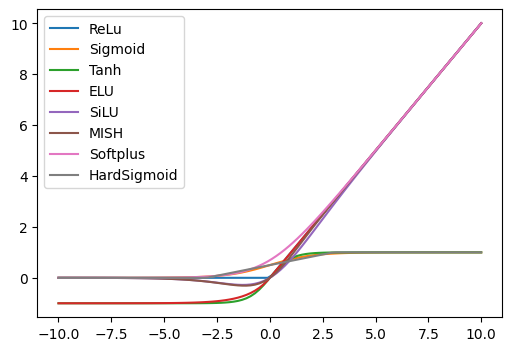

In [4]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

# Create a NumPy array
points = np.linspace(-10,10,100)

relu = F.relu(torch.from_numpy(points))
sigmoid = F.sigmoid(torch.from_numpy(points))
tanh = F.tanh(torch.from_numpy(points))
elu = F.elu(torch.from_numpy(points))
silu = F.silu(torch.from_numpy(points))
mish = F.mish(torch.from_numpy(points))
softplus = F.softplus(torch.from_numpy(points))
hardsigmoid = F.hardsigmoid(torch.from_numpy(points))

# Convert the NumPy array to a PyTorch tensor and calculate activation functions
plt.plot(points,relu, label = 'ReLu')
plt.plot(points,sigmoid, label = 'Sigmoid')
plt.plot(points,tanh, label = 'Tanh')
plt.plot(points,elu, label = 'ELU')
plt.plot(points,silu, label = 'SiLU')
plt.plot(points,mish, label = 'MISH')
plt.plot(points,softplus, label = 'Softplus')
plt.plot(points,hardsigmoid, label = 'HardSigmoid')

plt.legend()


In [5]:
!git clone https://github.com/prokudin/PHYS496-Fall2024.git

Cloning into 'PHYS496-Fall2024'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 110 (delta 22), reused 25 (delta 10), pack-reused 60 (from 1)
Receiving objects: 100% (110/110), 70.76 MiB | 28.61 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [6]:
# Path to the dataset (change this path if necessary)
filename1 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip (usually metadata or column labels in the file)
lines_to_skip = 5  # Skipping the first 5 lines which contain metadata

# Defining the columns (cv = central value, sd = standard deviation)
columns = ["x", "gluon_cv", "gluon_sd"]  # Columns represent x, gluon central value, and gluon standard deviation

# Read the data from the file and create a pandas DataFrame
df = pd.read_csv(filename1,
                 sep="\s+",  # The separator is whitespace
                 skiprows=lines_to_skip,  # Skip the first 5 lines
                 usecols=[0, 1, 2],  # Only use the first three columns (x, cv, sd)
                 names=columns)  # Name the columns as defined above

In [7]:
df_all = df.copy()

# Setting a random seed for reproducibility
np.random.seed(42)

df_all['gluon_cv'] += np.random.normal(0,df_all['gluon_sd'])

In [8]:
train_size = int(0.8*len(df_all))
val_size = len(df_all) - train_size

df_train, df_test = random_split(df_all,[train_size,val_size])

In [9]:
len(df_train)

800

In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
# Hyperparameters for the CNN model
n_features = 1        # Number of input features (for this example, we only have one input feature: 'x')
n_neurons_1 = 8       # Number of neurons in the first hidden layer
n_outputs = 1         # Number of output features (for regression, this is usually 1)
learning_rate = 0.01 # Learning rate for the optimizer, controls how much the model weights are adjusted during training
batch_size = 200      # Number of samples per mini-batch for training
n_epochs = 2000        # Number of complete passes through the training dataset


In [12]:
# Prepare training data
# Convert data to PyTorch tensors and move to the specified device (CPU/GPU)
x_train = torch.tensor(df_train.dataset['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_train = torch.tensor(df_train.dataset['gluon_cv'].values.reshape(-1, 1)).float().to(device) # Target values (gluon_cv)
dy_train = torch.tensor(df_train.dataset['gluon_sd'].values.reshape(-1, 1)).float().to(device) # Standard deviation (gluon_sd)

# Create a TensorDataset, which holds the input features (x_train), targets (y_train), and uncertainties (dy_train)
train_dataset = TensorDataset(x_train, y_train, dy_train)

# Create a DataLoader for the training dataset, which will handle batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data (similar to training data)
x_test = torch.tensor(df_test.dataset['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_test = torch.tensor(df_test.dataset['gluon_cv'].values.reshape(-1, 1)).float().to(device)  # Target values (gluon_cv)
dy_test = torch.tensor(df_test.dataset['gluon_sd'].values.reshape(-1, 1)).float().to(device)  # Standard deviation (gluon_sd)

# Create a TensorDataset for the test set
test_dataset = TensorDataset(x_test, y_test, dy_test)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
import torch
import torch.nn as nn
import torch.nn.utils.weight_norm as weight_norm

class Torch_Model_New(nn.Module):
    def __init__(self, n_features, n_neurons1, n_outputs):
        """
        Define the architecture of the neural network model.

        :param n_features: Number of input features (for example, 1 in this case).
        :param n_neurons1: Number of neurons in the first hidden layer.
        :param n_outputs: Number of output neurons (usually 1 for regression).
        """
        super().__init__()

        # Define the first fully connected layer (input layer to first hidden layer)
        self.fc1 = nn.Linear(n_features, n_neurons1)  # Hidden Layer 1 (input features to first hidden layer)

        #self.norm1 = nn.LayerNorm(n_neurons1) #torch.nn.LayerNorm: Layer normalization normalizes the activations within each layer, which can be useful for recurrent neural networks (RNNs).

        #self.dropout1 = nn.Dropout(0.2)
        # Define the final fully connected layer (second hidden layer to output)
        self.fc2 = nn.Linear(n_neurons1, n_outputs)  # Output Layer (no activation function for regression)

    def forward(self, x):
        """
        Forward pass of the network.

        :param x: Input tensor (of shape [batch_size, n_features]).
        :returns: Output tensor (of shape [batch_size, n_outputs]).
        """
        # Pass input through the first hidden layer and apply ReLU activation
        #out = F.relu(self.fc1(x)) # Apply  activation to the hidden layer, relu works worse
        #out = F.tanh(self.fc1(x)) # Apply  activation to the hidden layer, tanh works better
        #out = F.sigmoid(weight_norm(self.fc1(torch.log(x)))) # Apply  activation to the hidden layer, sigmoid works better
        out = self.fc1(torch.log(x))
        #out = self.norm1(out)
        #out = self.dropout1(out)
        out = F.sigmoid(out) # Apply  activation to the hidden layer, sigmoid works better
        #out = self.activation(out)  # Apply  activation

        # Pass through the output layer (no activation function for regression)
        out = self.fc2(out)

        return out



In [14]:
import torch
import torch.nn as nn
import torch.nn.utils.weight_norm as weight_norm

class Torch_Model_New1(nn.Module):
    def __init__(self, n_features, n_neurons1, n_neurons2, n_outputs):
        """
        Define the architecture of the neural network model.

        :param n_features: Number of input features (for example, 1 in this case).
        :param n_neurons1: Number of neurons in the first hidden layer.
        :param n_neurons2: Number of neurons in the second hidden layer.
        :param n_outputs: Number of output neurons (usually 1 for regression).
        """
        super().__init__()

        # Define the first fully connected layer (input layer to first hidden layer)
        self.fc1 = nn.Linear(n_features, n_neurons1)  # Hidden Layer 1 (input features to first hidden layer)
        self.fc2 = nn.Linear(n_neurons1, n_neurons2)  # Hidden Layer 2 (first hidden layer to second hidden layer)

        #self.norm1 = nn.LayerNorm(n_neurons1) #torch.nn.LayerNorm: Layer normalization normalizes the activations within each layer, which can be useful for recurrent neural networks (RNNs).

        #self.dropout1 = nn.Dropout(0.2)
        # Define the final fully connected layer (second hidden layer to output)
        self.fc3 = nn.Linear(n_neurons2, n_outputs)  # Output Layer (no activation function for regression)

    def forward(self, x):
        """
        Forward pass of the network.

        :param x: Input tensor (of shape [batch_size, n_features]).
        :returns: Output tensor (of shape [batch_size, n_outputs]).
        """
        # Pass input through the first hidden layer and apply ReLU activation
        #out = F.relu(self.fc1(x)) # Apply  activation to the hidden layer, relu works worse
        #out = F.tanh(self.fc1(x)) # Apply  activation to the hidden layer, tanh works better
        #out = F.sigmoid(weight_norm(self.fc1(torch.log(x)))) # Apply  activation to the hidden layer, sigmoid works better
        out = self.fc1(torch.log(x))
        #out = self.norm1(out)
        #out = self.dropout1(out)
        out = F.sigmoid(out) # Apply  activation to the hidden layer, sigmoid works better
        #out = self.activation(out)  # Apply  activation
        out = self.fc2(out)
        out = F.sigmoid(out) # Apply  activation to the hidden layer, sigmoid works better
        # Pass through the output layer (no activation function for regression)
        out = self.fc3(out)

        return out



In [15]:
class ChiSquareLoss(nn.Module):
    def __init__(self):
        """
        Initialize the Chi-Square loss class, inheriting from nn.Module.
        This will allow us to use it like any other PyTorch loss function.
        """
        super().__init__()

    def forward(self, y_pred, y_true, dy_true):
        """
        Forward pass of the custom Chi-Square loss function.

        :param y_pred: Predicted values from the model (tensor of shape [batch_size, n_outputs]).
        :param y_true: True values or target values (tensor of shape [batch_size, n_outputs]).
        :param dy_true: Standard deviation of the true values (tensor of shape [batch_size, n_outputs]).

        :return: Computed chi-square loss (scalar tensor).
        """
        # Compute the chi-square loss as the mean of ( (y_true - y_pred) / sigma )^2
        loss = torch.mean(((y_true - y_pred) / dy_true) ** 2)
        return loss

In [16]:
from IPython.display import clear_output, display

In [17]:
def plot_network(model):
    inputs = 10**np.linspace(-4, 0, 200, dtype="float32").reshape(-1, 1)
    outputs = model(torch.tensor(inputs)).detach().numpy()
    plt.plot(inputs, outputs)

To implement gradual decay of the learning rate during neural network training, you can use learning rate schedulers provided by libraries such as PyTorch, TensorFlow, or Keras. Here’s how you can do it in PyTorch, which is one of the most common frameworks for deep learning.

### PyTorch Implementation
1. **Using a Learning Rate Scheduler**
   PyTorch provides several schedulers to adjust the learning rate during training. Here’s an example using `StepLR`, which decays the learning rate by a factor every few epochs:

   ```python
   import torch
   import torch.optim as optim
   from torch.optim.lr_scheduler import StepLR

   # Define your model, loss, and optimizer
   model = ...
   optimizer = optim.SGD(model.parameters(), lr=0.1)
   scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decay every 10 epochs

   # Training loop
   for epoch in range(50):  # Example: 50 epochs
       train_loss = 0.0
       for data, target in train_loader:
           optimizer.zero_grad()
           output = model(data)
           loss = loss_fn(output, target)
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
       
       print(f"Epoch {epoch}, Loss: {train_loss}")
       scheduler.step()  # Update learning rate
   ```

2. **Cosine Annealing**
   If you want more gradual decay, `CosineAnnealingLR` is a good option:
   ```python
   from torch.optim.lr_scheduler import CosineAnnealingLR

   scheduler = CosineAnnealingLR(optimizer, T_max=50)  # T_max is the total number of epochs
   ```

3. **Lambda Function for Custom Decay**
   You can define a custom learning rate schedule using `LambdaLR`:
   ```python
   from torch.optim.lr_scheduler import LambdaLR

   # Define a custom lambda function
   lambda_lr = lambda epoch: 0.95 ** epoch  # Decay by 5% each epoch
   scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)
   ```

4. **Exponential Decay**
   For exponential decay, use `ExponentialLR`:
   ```python
   from torch.optim.lr_scheduler import ExponentialLR

   scheduler = ExponentialLR(optimizer, gamma=0.9)  # Decay rate
   ```

5. **Cyclic Learning Rates**
   Use `CyclicLR` if you want the learning rate to oscillate:
   ```python
   from torch.optim.lr_scheduler import CyclicLR

   scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=2000)
   ```

### Key Notes
- Ensure to call `scheduler.step()` after each epoch or step, depending on the scheduler.
- Monitor the learning rate during training to ensure it’s behaving as expected:
   ```python
   for epoch in range(epochs):
       print(f"Learning Rate: {scheduler.get_last_lr()}")
   ```



In [18]:
from torch.optim.lr_scheduler import CosineAnnealingLR



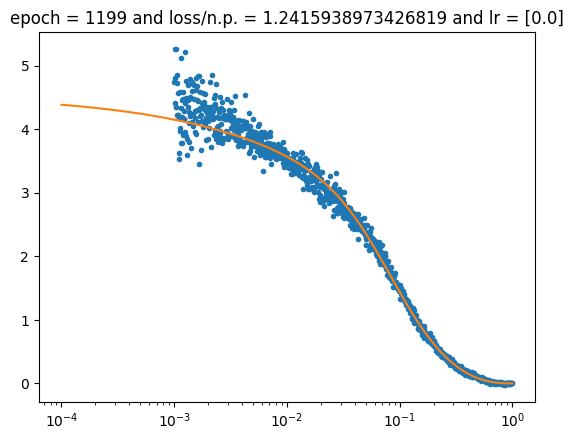

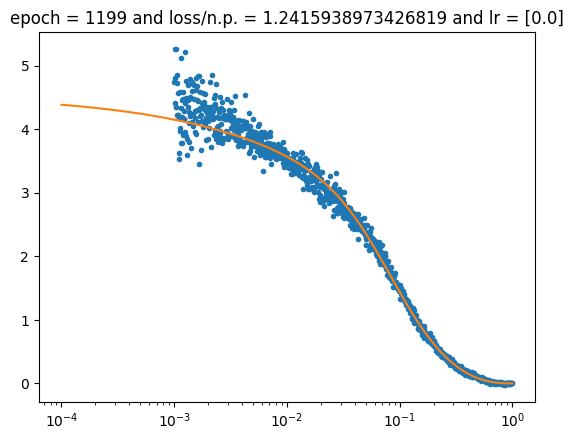

In [19]:
# Hyperparameters for the CNN model
n_features = 1        # Number of input features (for this example, we only have one input feature: 'x')
n_neurons_1 = 8       # Number of neurons in the first hidden layer
n_neurons_2 = 16       # Number of neurons in the second hidden layer
n_outputs = 1         # Number of output features (for regression, this is usually 1)
learning_rate = 0.06 # Learning rate for the optimizer, controls how much the model weights are adjusted during training
weight_decay  = 0.05    # Adjusting regularization strength is an important step to control overfitting or underfitting in your model. Regularization adds a penalty to the loss function to discourage the model from fitting noise or over-complicating its parameters.
l1_lambda = 0.001  # Regularization strength
batch_size = 800      # Number of samples per mini-batch for training
n_epochs = 1200        # Number of complete passes through the training dataset


# We need to recreate a DataLoader for the training dataset, which will handle batching and shuffling
# as batch_size may become different when we explore the notebook
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# We need to recreate a a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, more complicated compared to the test above
model = Torch_Model_New(n_features=1, n_neurons1=n_neurons_1, n_outputs=1).to(device)
#model = Torch_Model_New1(n_features=1, n_neurons1=n_neurons_1, n_neurons2=n_neurons_2, n_outputs=1).to(device)

# Define loss function and optimizer
criterion = ChiSquareLoss()  # Mean Squared Error for regression
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 regularization strength = 0.01


# Using a Learning Rate Scheduler PyTorch provides several schedulers to adjust the learning rate during training.
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)  # T_max is the total number of epochs

#backend_inline.set_matplotlib_formats('png')
# animation works terribly slow with svg, so we fallback to png


fig, ax = plt.subplots()
# created a figure and axes to draw on them


train_losses = []
test_losses = []
# Training loop
for epoch in range(n_epochs):
    model.train()  # Put the model in training mode
    running_loss = 0.0

    for x_batch, y_batch, dy_batch in train_loader:  # Note: Uncertainty (dy_train) is not used here
        # Forward pass
        outputs = model(x_batch)


        loss = criterion(outputs, y_batch, dy_batch)
        # L1 Regularization Penalizes the absolute values of the weights, promoting sparsity (some weights are driven to zero).
        l1_penalty = sum(param.abs().sum() for param in model.parameters())
        loss += l1_lambda * l1_penalty

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # Clip gradient norm


        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss)

    scheduler.step()  # Update learning rate

    # Here we alculate the losses on a test data, we do not use the data in training and hence no_grad()
    with torch.no_grad():
      model.eval() # Put the model in evaluation mode
      test_loss = 0.0
      for x_batch, y_batch, dy_batch in test_loader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch, dy_batch)

        l1_penalty = sum(param.abs().sum() for param in model.parameters())
        loss += l1_lambda * l1_penalty

        test_loss += loss.item()
      test_losses.append(test_loss)

    #plot_graphs(epoch, n_epochs, train_losses, test_losses, model, x_test, y_test, df_train, dy_train)

    if epoch % 400 == 0 or epoch == n_epochs - 1 :
        #print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')
        #print(f"Learning Rate: {scheduler.get_last_lr()}")
        clear_output(wait=True)
        plt.gca().clear()
        # clear the axes

        plt.xscale('log')
        plt.plot(x_train, y_train, ".")
        plot_network(model)
        # plot everything

        plt.title(f"epoch = {epoch} and loss/n.p. = {running_loss/len(train_loader)} and lr = {scheduler.get_last_lr()}")
        display(fig)

Save the model

In [21]:
torch.save(model,"model_alexei.pth")

Load

In [22]:
mymodel = torch.load("model_alexei.pth",weights_only=False)

In [23]:
scheduler.get_last_lr()

[0.0]

In [24]:
summary(mymodel)

Layer (type:depth-idx)                   Param #
Torch_Model_New                          --
├─Linear: 1-1                            16
├─Linear: 1-2                            9
Total params: 25
Trainable params: 25
Non-trainable params: 0

In [25]:
print(mymodel)

Torch_Model_New(
  (fc1): Linear(in_features=1, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [26]:
def plot_loss(train_losses, test_losses):
    """
    Function to plot the training loss over epochs and the model predictions on the test data.

    :param train_losses: A list of training losses for each epoch.
    :param model: The PyTorch model that has been trained.
    """

    # Plot 1: Training Loss (in log scale)
    plt.figure(figsize=(6, 4))
    # Plot the log of the training losses to better visualize the loss progression.
    plt.plot(np.log(train_losses), label='Train Loss')
    plt.plot(np.log(test_losses), label='Test Loss')
    plt.xlabel('Epoch')  # X-axis is the epoch number
    plt.ylabel('Log(Loss)')  # Y-axis is the log of the training loss
    plt.legend()  # Add a legend
    plt.show()

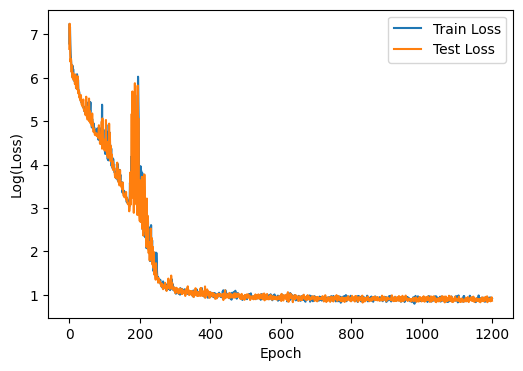

In [27]:
plot_loss(train_losses, test_losses)

In [28]:
# Read the data from the file and create a pandas DataFrame
df = pd.read_csv(filename1,
                 sep="\s+",  # The separator is whitespace
                 skiprows=lines_to_skip,  # Skip the first 5 lines
                 usecols=[0, 1, 2],  # Only use the first three columns (x, cv, sd)
                 names=columns)  # Name the columns as defined above

In [29]:
x_test1 = torch.tensor(df['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_test1 = torch.tensor(df['gluon_cv'].values.reshape(-1, 1)).float().to(device)    # Input values (y)
dy_test1 = torch.tensor(df['gluon_sd'].values.reshape(-1, 1)).float().to(device)    # Input errors (dy)

In [30]:
mymodel.eval()
y_prediction = mymodel(x_test1)

In [31]:
loss = criterion(y_prediction, y_test1, dy_test1)

In [32]:
loss/len(y_test1)

tensor(0.0003, grad_fn=<DivBackward0>)

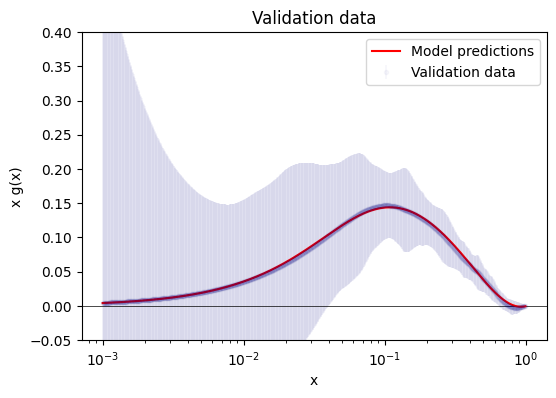

In [33]:
# Create a figure with 1 row and 2 subplots, with a defined figure size
fig, ax = plt.subplots(1, 1, figsize=(6, 4))



ax.errorbar(df['x'], df['x']*df['gluon_cv'], df['gluon_sd'], fmt='.', color='darkblue', label='Validation data', alpha=0.03) # Plot the true test values
#ax.errorbar(df['x'], df['gluon_cv'], df['gluon_sd'], fmt='.', color='darkblue', label='Validation data', alpha=0.03) # Plot the true test values
ax.axhline(0, color='k', linewidth=0.5)  # Draw a horizontal line at y=0 for reference
ax.plot(x_test1.detach().cpu().numpy(), x_test1.detach().cpu().numpy()*y_prediction.detach().cpu().numpy(), label='Model predictions', color='red')  # Model results
#ax.plot(x_test1.detach().cpu().numpy(), y_prediction.detach().cpu().numpy(), label='Model predictions', color='red')  # Model results

ax.set_title("Validation data")  # Title for the train data plot
ax.set_xlabel("x")  # X-axis label
ax.set_ylabel("x g(x)")  # Y-axis label
ax.set_ylim(-0.05, 0.4)  # Set limits for the Y-axis
ax.legend()
ax.set_xscale('log')